### Model
- Qwen 0.5B Base
- Qwen 1.8B Base
### Data:
- Resource: General + Medical
- Format: ChatML
### Method
- SFT
- QLoRA + FlashAttention2 + Two-Stage
#### Two-Stage
- Stage 1: Understanding Tasks = 20w
- Stage 2: Understanding Tasks + Generation Tasks = 20w + 20w
### Downstream
- NER
- RE
- Translation
- QA
### BioQwen
- BioQwen 0.5B
- BioQwen 1.8B

## Import

In [1]:
# !pip install bitsandbytes gradio trl peft ipywidgets wandb zhconv datasets transformers accelerate matplotlib pandas torch

In [2]:
import os
import math
import copy
import json
import torch
import torch.nn as nn
import concurrent.futures
import pandas as pd
import bitsandbytes as bnb
import gradio as gr
from accelerate.state import PartialState
from trl import get_kbit_device_map, KTOTrainer, KTOConfig, DPOTrainer
from zhconv import convert

from peft import LoraConfig, get_peft_model, PeftModel, prepare_model_for_kbit_training
from datasets import load_dataset, concatenate_datasets, Dataset, load_from_disk
from transformers import (
    AutoTokenizer, 
    AutoModelForCausalLM, 
    BitsAndBytesConfig, 
    Trainer, 
    TrainingArguments,
    TextStreamer,
    pipeline, 
    AutoModelForSequenceClassification, 
    LlamaTokenizer
)

import matplotlib.pyplot as plt

In [4]:
train_mode = 'qlora'
max_length = 1024

In [5]:
torch.cuda.device_count()

4

## Data

### COIG 44694 -> 36525

- Title: COIG-CQIA: Quality is All You Need for Chinese Instruction Fine-tuning
- Link: https://arxiv.org/abs/2403.18058

In [56]:
general_data = load_dataset('json', data_files='data/COIG-CQIA/COIG-CQIA-full.jsonl')
general_data

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output', 'task_type', 'domain', 'metadata', 'answer_from', 'human_verified', 'copyright'],
        num_rows: 44694
    })
})

In [57]:
general_data.filter(lambda x: x['answer_from'] == 'human')

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output', 'task_type', 'domain', 'metadata', 'answer_from', 'human_verified', 'copyright'],
        num_rows: 42847
    })
})

In [58]:
general_data['train'].shuffle()[0]

{'instruction': '请判断下面文本中是否包含[人名,地名,机构名]等词汇，如果存在，返回包含词汇对应的标签，如果不存在，返回No',
 'input': '文本：与上年相比，巢湖和滇池污染程度有所加重，太湖有所减轻。\n',
 'output': '地名\n',
 'task_type': {'major': ['分类'], 'minor': ['实体判断']},
 'domain': ['通用'],
 'metadata': '暂无元数据信息',
 'answer_from': 'human',
 'human_verified': False,
 'copyright': '暂无版权及作者信息'}

In [59]:
# remove medical-related content
general_data = general_data.filter(lambda x: not any(domain in x['domain'] for domain in ['医学', '医疗', '药物']))
general_data

In [60]:
selected_general_data = general_data.map(remove_columns=['task_type', 'domain', 'metadata', 'answer_from', 'human_verified', 'copyright'])
selected_general_data

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 44694
    })
})

In [61]:
selected_general_data = selected_general_data['train']

In [62]:
selected_general_data.shuffle()[0]

{'instruction': '你是一名领域专家，对体验效用这个概念非常了解，请给出详细的解释',
 'input': '',
 'output': '#### 体验效用概述\n\nKahnemanetal.(1997)在借鉴积极心理学知识的基础上开创性地区分了经济学中的两种效用：决策效用(decisionutility)和体验效用(experiencedutility)。他们认为，在当前经济学的决策理论中，效用是指决策效用，结果和属性的效用是指它们在决策中的权重。也就是说，效用是通过观察到的选择来推导出的，而且又用于解释这些选择(Kahneman&Thaler，2006)。体验效用是边沁所指的效用，即幸福与痛苦，指导着“我们应该做什么”和“将要做什么”。积极效用是能带来快乐的倾向，与此相反，带来痛苦的倾向就是消极效用。在区分两种效用的基础上，他们提出了基于体验效用时刻评价方式的体验幸(experiencedwell-being)的概念。#### 体验效用、预测效用和决策效用\n\n体验效用、预测效用和决策效用(experienced、predicted、decisionutility)是三种探讨效用的方式，它们之间存在着很大的差异(Kahneman，1994；Kahneman，Frederickson，Schrciber和Redelmeier，1993；Kahneman和Snell，1992；Varey和Kahneman，1992)。实质上，体验效用非常重要(这个术语可以使我们得出经历才是最重要的假定，在这里我将否定这个假定。但是我们可以在这些主要差异存在的同时，将它的意义拓展到包括很多种类的目标实现中)。如果你品尝两种啤酒，那么对于每种啤酒的体验都是真实(体验)效用。预测效用是指你对每种体验会有多好的判断，很可能是基于你对以前体验的记忆而做出的。为了衡量你的决策效用，我将让你对每种啤酒做出评价。依据决策效用能推论出你的选择。我可以观察你选择哪种啤酒。\n这三种效用可能会冲突。啤酒A(拥有更多的体验效用)的口感可能会好于啤酒B，但是你的预测可能正相反。举个例子，你可能有种天真的想法，认为你有段时间没有喝的啤酒的口感会很好。你的预测可能就是基于你很长时间没有喝过啤酒B了。否则你就会预测A的口感会更好，但是依据人们都喜欢追求变化这样一个普遍的启发式，无论如何你还是会

### QA 763629

- Title: MedChatZH: a Better Medical Adviser Learns from Better Instructions
- Link: https://arxiv.org/abs/2309.01114

#### Load

In [7]:
qa_data = load_dataset('json', data_files='data/MedChatZH/MedChatZH_train.json')
qa_data

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 763629
    })
})

In [8]:
qa_data['train'].shuffle()[0]

{'instruction': '女人吃什么能补气血',
 'input': '',
 'output': '女人吃什么能补气血，补气血吃的东西特别的多，下面就是补气血需要吃哪些食物。红豆，红豆不仅营养成分高，女性多食物还能帮助起到排毒养颜的效果，因为其铁质含量相当丰富，具有很好的补血功能。莲藕，莲藕含丰富淀粉及各种营养物质，有最符合人体所需求的各种营养，能帮助起到补气益血，增强免疫力的作用，而且容易消化。菠菜，这是最常见的蔬菜，也是有名的补血食物，菠菜内含有丰富的铁质胡萝卜素，所以菠菜可以算是补血蔬菜中的重要食物。如果不爱吃胡萝卜，那就多吃点蔬菜吧。桑葚干，桑葚干是目前水果及其制品中含天然铁最丰富的，每100克含铁\n42. 5毫克，是水果中的补血果。一般建议将桑葚干煮粥吃，每日食用一碗桑葚粥不但可以补血，还可以美容。牛奶，牛奶最宜人，平补血脉、益心、长肌肉、令人身体健康、面目光悦、志不急，故为子者常须供之，以为常食。因此女性朋友可以通过多喝牛奶来达到补气血、滋养的功效。红枣，天方健红枣是补血的人首选的食物，它含有大量的环磷酸腺苷，它能调节人体的新陈代谢，使新细胞迅速生成，死细胞很快被消除，并能增强骨髓造血功能，增强血液中红细胞的含量。龙眼肉，龙眼肉就是桂圆肉，任何一家超市都有售。龙眼肉除了含丰富的铁质外还含有蔗糖。补血的同时还能治疗健忘、心悸、神经衰弱和失眠症。龙眼汤、龙眼胶、龙眼酒之类也是很好的补血食物等。气血这种病不可怕，不用担心，不要有心里有压力，可以从多方面可以补的，平常多注意休息。'}

#### Eliminate low-quality data

In [9]:
bioqwen_tokenizer = AutoTokenizer.from_pretrained("yueqingyou/BioQwen-1.8B")
bioqwen_tokenizer

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Qwen2TokenizerFast(name_or_path='bio-qwen-stage1-merged/', vocab_size=151643, model_max_length=32768, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'eos_token': '<|endoftext|>', 'pad_token': '<|padoftext|>', 'additional_special_tokens': ['<|im_start|>', '<|im_end|>']}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	151643: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	151644: AddedToken("<|im_start|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	151645: AddedToken("<|im_end|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	151646: AddedToken("<|padoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [13]:
qa_data = qa_data.filter(lambda x: len(bioqwen_tokenizer.encode(x['instruction'] + x['input'])) < (max_length * 0.5) and 
                         len(bioqwen_tokenizer.encode(x['output'])) < (max_length * 0.5))

qa_data

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 727633
    })
})

In [22]:
tokenizer = LlamaTokenizer.from_pretrained("model/Ziya-LLaMA-7B-Reward", add_eos_token=True)

reward_model = AutoModelForSequenceClassification.from_pretrained("model/Ziya-LLaMA-7B-Reward", 
                                                                  trust_remote_code=True,
                                                                  torch_dtype=torch.bfloat16,
                                                                 ).eval().cuda()

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [23]:
def reward(query, response):
    prefix_user = "Human:"
    prefix_bot = "\n\nAssistant:"
    text = prefix_user+query+prefix_bot+response
    batch = tokenizer(text, return_tensors="pt",padding=True,truncation=True,max_length=1024)
    
    with torch.no_grad():
        reward = reward_model(batch['input_ids'].cuda(), attention_mask = batch['attention_mask'].cuda())
        return reward.item()

In [12]:
def append_score_batch(examples):
    prompts = [inp + instr for inp, instr in zip(examples['input'], examples['instruction'])]
    responses = examples['output']
    scores = [reward(prompt, response) for prompt, response in zip(prompts, responses)]  # Assuming reward is vectorized
    examples['score'] = scores
    return examples

#### Save

In [14]:
scores = pd.read_json('score-qa-data/final_results.json')
scores.columns = ['score']
scores.head()

,score
0,1.539062
1,3.218750
2,-0.027222
3,2.218750
4,1.273438


In [15]:
scores.shape

(727633, 1)

In [16]:
scores.min(), scores.max()

(score   -12.75
 dtype: float64,
 score    7.125
 dtype: float64)

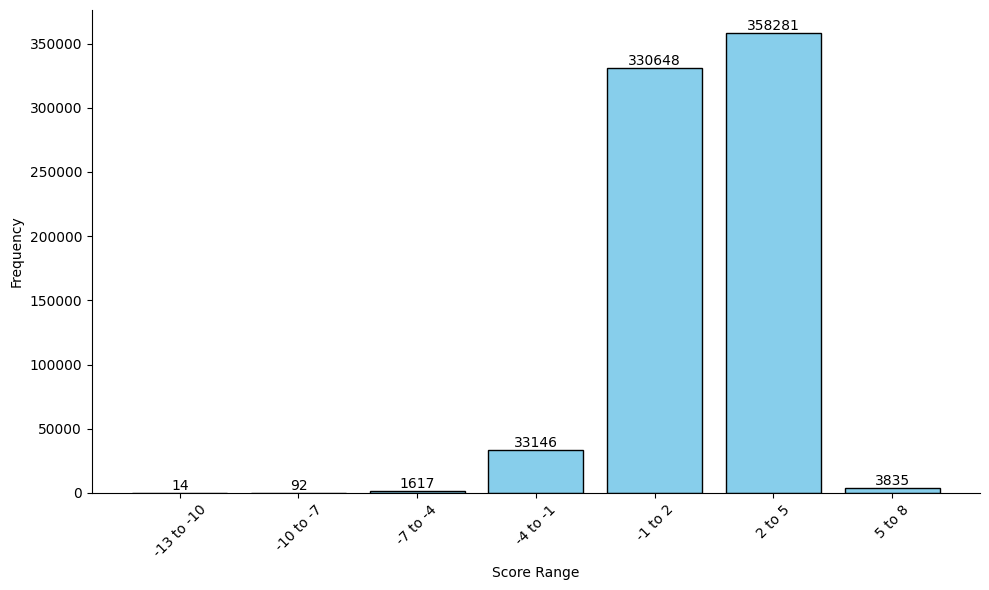

In [30]:
# Define score bins
bins = [-13, -10, -7, -4, -1, 2, 5, 8]
labels = ['-13 to -10', '-10 to -7', '-7 to -4', '-4 to -1', '-1 to 2', '2 to 5', '5 to 8']

# Assign scores to bins
scores['score_range'] = pd.cut(scores['score'], bins=bins, labels=labels)

# Calculate frequency for each score range
score_counts = scores['score_range'].value_counts().sort_index()

# Plot histogram
plt.figure(figsize=(10, 6))
bars = plt.bar(score_counts.index, score_counts.values, color='skyblue', edgecolor='black')

# Add count labels on each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.1, int(yval), ha='center', va='bottom')

plt.xlabel('Score Range')
plt.ylabel('Frequency')
#plt.title('Frequency Distribution of Scores')
plt.xticks(rotation=45)
plt.gca().spines['top'].set_visible(False)  # Hide the top spine
plt.gca().spines['right'].set_visible(False)  # Hide the right spine
plt.tight_layout()
plt.show()

/tmp/ipykernel_829816/223471496.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_scores['score_range'] = pd.cut(filtered_scores['score'], bins=bins, labels=labels)


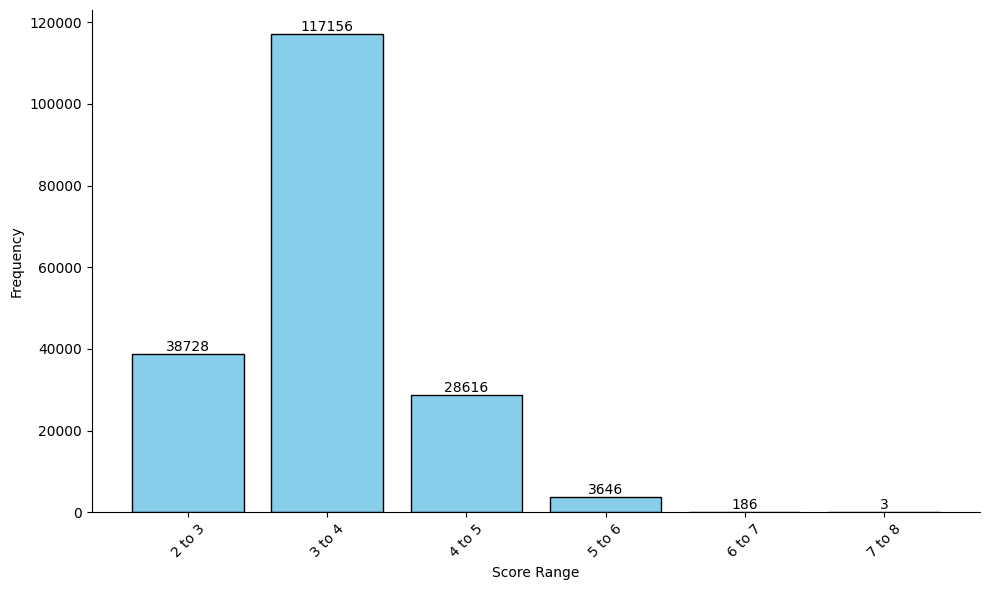

In [31]:
# Define score bins
bins = [2, 3, 4, 5, 6, 7, 8]
labels = ['2 to 3', '3 to 4', '4 to 5', '5 to 6', '6 to 7', '7 to 8']

# Assign scores to bins
filtered_scores['score_range'] = pd.cut(filtered_scores['score'], bins=bins, labels=labels)

# Calculate frequency for each score range
score_counts = filtered_scores['score_range'].value_counts().sort_index()

# Plot histogram
plt.figure(figsize=(10, 6))
bars = plt.bar(score_counts.index, score_counts.values, color='skyblue', edgecolor='black')

# Add count labels on each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.1, int(yval), ha='center', va='bottom')

plt.xlabel('Score Range')
plt.ylabel('Frequency')
# plt.title('Frequency Distribution of Filtered Scores')
plt.xticks(rotation=45)
plt.gca().spines['top'].set_visible(False)  # Hide the top spine
plt.gca().spines['right'].set_visible(False)  # Hide the right spine
plt.tight_layout()
plt.show()

In [46]:
filtered_qa_data = qa_data['train'].select(filtered_scores.index)
filtered_qa_data

Dataset({
    features: ['instruction', 'input', 'output'],
    num_rows: 188335
})

In [47]:
filtered_qa_data.save_to_disk('filtered_qa_data')

Saving the dataset (0/1 shards):   0%|          | 0/188335 [00:00<?, ? examples/s]

#### Load

In [48]:
selected_qa_data = load_from_disk('filtered_qa_data/')
selected_qa_data

Dataset({
    features: ['instruction', 'input', 'output'],
    num_rows: 188335
})

### Understanding Tasks(RE NER MT) 157328

- Title: Taiyi: A Bilingual Fine-Tuned Large Language Model for Diverse Biomedical Tasks
- Link: https://arxiv.org/abs/2311.11608

In [5]:
other_data = load_dataset('json', data_files='data/Taiyi_Instruction_Data_001/Taiyi_Instruction_Data_001.jsonl')
other_data

DatasetDict({
    train: Dataset({
        features: ['conversation_id', 'category', 'dataset', 'language', 'conversation'],
        num_rows: 3829368
    })
})

In [6]:
other_data['train'].shuffle()[0]

{'conversation_id': 9055,
 'category': 'TC',
 'dataset': 'bc7_litcovid',
 'language': 'en',
 'conversation': [{'human': 'Document triage: "Origin and cross-species transmission of bat coronaviruses in China. Bats are presumed reservoirs of diverse coronaviruses (CoVs) including progenitors of Severe Acute Respiratory Syndrome (SARS)-CoV and SARS-CoV-2, the causative agent of COVID-19. However, the evolution and diversification of these coronaviruses remains poorly understood. Here we use a Bayesian statistical framework and a large sequence data set from bat-CoVs (including 630 novel CoV sequences) in China to study their macroevolution, cross-species transmission and dispersal. We find that host-switching occurs more frequently and across more distantly related host taxa in alpha- than beta-CoVs, and is more highly constrained by phylogenetic distance for beta-CoVs. We show that inter-family and -genus switching is most common in Rhinolophidae and the genus Rhinolophus. Our analyses i

##### Filter

In [22]:
filtered_other_data = other_data.filter(lambda x: x['category'] in ['NER', 'RE', 'MT-zh2en', 'MT-en2zh'])
filtered_other_data

DatasetDict({
    train: Dataset({
        features: ['conversation_id', 'category', 'dataset', 'language', 'conversation'],
        num_rows: 195568
    })
})

In [23]:
filtered_other_data['train'].shuffle()[0]

{'conversation_id': 86,
 'category': 'NER',
 'dataset': 'tmvar_v2',
 'language': 'en',
 'conversation': [{'human': 'What are the DNAMutation, ProteinMutation, SNP entities in the following text?\nMolecular analysis of acute intermittent porphyria: mutation screening in 20 patients in Germany reveals 11 novel mutations. Acute intermittent porphyria (AIP) is a very rare autosomal dominant disorder with low penetrance. Mutations in the gene of the porphobilinogen deaminase (PBG-D), also called hydroxymethylbilane synthase (HMBS), cause a partial deficiency of this enzyme of the heme biosynthetic pathway. Overstimulation of heme biosynthesis causes clinical symptoms. Because of the variability of the symptoms, diagnosis is often delayed. Using two approaches for genetic analysis, first in a stepwise manner, then sequencing extensive parts of the gene, the screening of the DNA of 20 unrelated individuals revealed 20 different mutations, 11 of which had not been reported previously. The nove

In [24]:
def filter_fields(example):
    example = example['conversation'][0]
    return {
        'instruction': example['human'],
        'input': '',
        'output': example['assistant']
    }

selected_filtered_other_data = filtered_other_data.map(filter_fields, remove_columns=filtered_other_data['train'].column_names)
selected_filtered_other_data

Map:   0%|          | 0/195568 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 195568
    })
})

In [25]:
selected_filtered_other_data = selected_filtered_other_data['train']

In [27]:
selected_filtered_other_data.shuffle()[0]

{'instruction': 'Please translate the following sentences into Chinese: "Prevalence of loss of activities of daily living and influencing factors in elderly population in China"',
 'input': '',
 'output': '中国老年人日常生活活动能力损失现况及影响因素分析'}

### Self Cognition 80

In [2]:
cognition_data = load_dataset('json', data_files='data/self_cognition.json')
cognition_data

In [29]:
cognition_data = cognition_data['train']

In [40]:
cognition_data.shuffle()[0]

{'output': '您好，我的名字是千问生物智能助手，请问有什么可以帮助您的吗？',
 'instruction': '你好，我叫小明，请问你叫什么名字',
 'input': ''}

### Remove long content

In [80]:
selected_general_data = selected_general_data.filter(lambda x: len(bioqwen_tokenizer.encode(x['instruction'] + x['input'] + x['output'])) < max_length - 100)
selected_general_data

Filter:   0%|          | 0/33003 [00:00<?, ? examples/s]

Dataset({
    features: ['instruction', 'input', 'output'],
    num_rows: 33003
})

In [81]:
selected_qa_data

Dataset({
    features: ['instruction', 'input', 'output'],
    num_rows: 251495
})

In [82]:
cognition_data

Dataset({
    features: ['output', 'instruction', 'input'],
    num_rows: 83
})

In [3]:
selected_filtered_other_data = selected_filtered_other_data.filter(lambda x: len(bioqwen_tokenizer.encode(x['instruction'] + x['input'])) < (max_length * 0.5) and 
                                                                   len(bioqwen_tokenizer.encode(x['output'])) < (max_length * 0.5))
selected_filtered_other_data

In [7]:
question = qa_data['train']['instruction']
output = qa_data['train']['output']
len(question), len(output)

(288086, 288086)

In [8]:
question[10], output[10]

('提供一些预防牙周病的方法和最好的治疗方案。牙周病治疗，口腔保健',
 '预防牙周病的方法包括定期刷牙、使用牙线进行清洁、注意口腔卫生和饮食习惯等。最好的治疗方案会根据患者的具体情况而定，可能会包括口腔清洁治疗、局部或全身药物治疗、手术治疗等。如果患者遵守医生给出的治疗方案并保持良好的口腔卫生习惯，可以有效地预防和治疗牙周病。同时，也建议定期到牙医处接受口腔检查和清洁，以及留意口腔状况，尽早发现并治疗相关问题。')

In [9]:
response = gemini_model.generate_content("一开始门头长了很多红痘痘，脸上也有少，做了一段时间的面部清理和护理好多了，现在门头上没有红痘有的是小粒状的硬痘，护理的人说毛孔堵涩排不出毒素让刮痧")
result = response.candidates[0].content.parts[0].text
result

'建议不要盲目刮痧。刮痧对于某些特定情况可能有帮助，但对于门头小粒状硬痘是否有效尚无科学证据支持。\n\n针对门头小粒状硬痘，建议采取以下措施：\n\n* **保持清洁：**每天使用温和的洁面乳清洗门头，以清除多余的油脂和污垢。\n* **使用非粉刺产品：**选择专门针对敏感和痤疮皮肤配制的护肤品和化妆品。避免使用含香料、染料或刺激性成分的产品。\n* **保湿：**使用不含油的保湿霜来滋润门头，防止因干燥而产生更多皮脂。\n* **避免挤痘痘：**挤痘痘会加重炎症，导致疤痕形成。\n* **咨询皮肤科医生：**如果经过一段时间的自我护理后，门头小粒状硬痘仍未改善，建议咨询皮肤科医生。医生可以评估你的皮肤状况并推荐合适的治疗方案，如局部用药或光疗。\n\n刮痧是一种传统疗法，其疗效因人而异。对于门头小粒状硬痘，刮痧可能无法提供显著改善。此外，刮痧还可能导致皮肤损伤或瘀青，加重皮肤问题。\n\n在尝试任何新疗法之前，始终建议咨询合格的医疗专业人员。'

In [10]:
def generate_content_with_thread(prompt, rejected):
    try:
        response = gemini_model.generate_content(prompt)
        if not response.candidates:
            raise ValueError("No candidates returned from the model")
        return {
            'instruction': prompt,
            'chosen': response.candidates[0].content.parts[0].text,
            'rejected': rejected
        }
    except Exception as e:
        print(f"Error processing prompt '{prompt}': {str(e)[:20]}")

def generate_dpo_dataset(prompts, rejected_texts):
    with open('dpo_data.jsonl', 'w') as file:
        with concurrent.futures.ThreadPoolExecutor(max_workers=3) as executor:
            futures = [executor.submit(generate_content_with_thread, p, r) for p, r in zip(prompts, rejected_texts)]
            for future in concurrent.futures.as_completed(futures):
                try:
                    result = future.result()
                    if result:
                        file.write(json.dumps(result, ensure_ascii=False) + '\n')
                        file.flush()
                except Exception as exc:
                    print(f'Generated an exception: {exc}')

In [ ]:
generate_dpo_dataset(question, output)

Error processing prompt '弱精患者治疗误区，对弱精症经常拥有的救治误区有哪些？最近去医院仔细检查被告之患上了弱精症，如果不及时救治的话还会干扰受孕，通说对弱精症经常拥有救治误区，担心自己也会走进这些误区，所以想要理解一下。想要问一下医生对弱精症经常拥有的救治误区有哪些。': list index (0) out o
Error processing prompt '我想请问一下我得水痘第四天了能少量吸烟吗？憋了好几天已经憋不住了对病情会有什么影响吗': list index (0) out o
Error processing prompt '治疗外痔疮用什么药更好？，女32岁知道身体有不适的感觉，就没用去看，请问：治疗外痔疮用什么药更好？': list index (0) out o
Error processing prompt '得了宫颈炎，日常要注意什么？，得了宫颈炎，日常要注意什么？平常有什么东西排出，很是烦脑。可以根治吗': list index (0) out o
Error processing prompt '上周在医院检查确诊是有生殖器疱疹感染已经治疗了一段时间了，最近是要考虑出差。我现在想知道生殖器疱疹感染治愈标准是什么？': list index (0) out o
Error processing prompt '之前吃利培酮后到5月6号后阳痿，然后停药一直阳痿，请问怎么医治.': list index (0) out o
Error processing prompt '我包皮太长，龟头露不出来。而且总觉得有异味很不卫生，如果做割包皮手术的话多久可以恢复，对我以后会不会有影响。': list index (0) out o
Error processing prompt '注射用阿莫西林钠舒巴坦钠的副作用（不良反应）': list index (0) out o
Error processing prompt '月经推迟6天了最近两天腹部有点疼，肚子还有胀气，胃热。但是还有想来月经的感觉，请问这是怎么回事？': list index (0) out o
Error processing prompt '就是我上上个月，月经推迟22，4月26号来的，来了7天，比以往的多三天，上个月推迟6天，6月2号来的，来了四天，前

In [14]:
# def generate_dpo_dataset(prompt, rejected):
#     result = []
#     for p, r in zip(prompt, rejected):
#         gemini_response = gemini_model.generate_content(p)
#         result.append(
#             {
#                 'instruction': p,
#                 'chosen': gemini_response.candidates[0].content.parts[0].text, 
#                 'rejected': r
#             })
#     return result

In [15]:
# example = generate_dpo_dataset(question[:2], output[:2])
# example[0]

{'instruction': '医生您好，请问金黄色葡萄球菌是什么引起的',
 'chosen': '金黄色葡萄球菌是一种细菌，可引起广泛的感染，包括：\n\n* **皮肤感染：**疖肿、脓疱、蜂窝组织炎、脓皮病\n* **呼吸道感染：**肺炎、鼻窦炎、咽炎\n* **血液感染：**菌血症、脓毒症\n* **骨骼和关节感染：**骨髓炎、化脓性关节炎\n* **眼部感染：**结膜炎、睑腺炎\n* **心脏瓣膜感染：**感染性心内膜炎\n* **中枢神经系统感染：**脑膜炎、脓肿\n* **中毒性休克综合征（TSS）：**一种罕见但危及生命的感染性疾病',
 'rejected': '金黄色葡萄球菌是一种常见的细菌，可以引起各种感染，包括皮肤感染、软组织感染、心内膜炎、肺炎等。一般情况下，人们会通过接触污染物品或者其他感染者的皮肤表面接触到金黄色葡萄球菌。此外，金黄色葡萄球菌也可以在医院等医疗环境中感染患者。因此，保持个人卫生，勤洗手，避免接触感染源是预防金黄色葡萄球菌感染的有效措施。'}

In [16]:
# example[1]

{'instruction': '淋巴癌有什么并发症吗？，患有淋巴癌，医生建议手术治疗',
 'chosen': '**淋巴癌的并发症**\n\n* **复发：**淋巴癌在原发部位或身体其他部位复发的可能性。\n* **进展：**淋巴癌扩散到身体其他部位，病情恶化。\n* **感染：**淋巴癌会损害免疫系统，使患者更容易受到感染。\n* **贫血：**淋巴癌会导致骨髓抑制，导致贫血。\n* **出血：**淋巴癌可导致血小板减少，增加出血风险。\n* **心脏问题：**某些淋巴瘤治疗方法（如化疗和放疗）会增加心脏损伤的风险。\n* **肺部问题：**放疗或其他治疗方法可能会损害肺部。\n* **肝脏损伤：**某些淋巴瘤药物可能会损害肝脏。\n* **肾脏损伤：**某些淋巴瘤药物可能会损害肾脏。\n* **神经损伤：**化疗或放疗可能会导致神经损伤，引起麻木、刺痛或无力。\n* **继发性肿瘤：**淋巴瘤治疗可能会增加其他类型癌症的风险。\n\n**手术治疗的并发症**\n\n手术治疗淋巴癌也可能带来以下并发症：\n\n* **出血：**手术部位出血。\n* **感染：**手术部位感染。\n* **伤口愈合问题：**伤口愈合延迟或不良。\n* **淋巴水肿：**淋巴结切除术后淋巴液积聚。\n* **神经损伤：**手术过程中可能损伤神经，导致麻木、刺痛或无力。\n* **疤痕：**手术部位可能出现疤痕。',
 'rejected': '1. 胃肠道 食欲减退、腹痛，腹泻、腹块、肠梗阻和出血等。\n2. 肝胆 肝实质受侵可引起肝区疼痛。\n3. 骨骼 临床表现有局部骨骼疼痛及继发性神经压迫症状。\n4. 皮肤 非特异性损害常见的有皮肤瘙痒症及痒疹。瘙痒症在霍奇金病较为多见(占85%)。\n5. 扁桃体和口、鼻、咽部 淋巴瘤侵犯口、鼻、咽部者，临床有吞咽困难、鼻塞、鼻衄。\n6. 其他 淋巴瘤尚可浸润胰腺，发生吸收不良综合征。'}

In [15]:
# pd.DataFrame.from_records(example).to_json('../data/test_dpo.jsonl', lines=True, orient='records', force_ascii=False)

In [6]:
def dpo2kto(single_example):
    zh_system = "你是千问生物智能助手，一个专注于生物领域的先进人工智能。"

    prompts = []
    completions = []
    labels = []
    
    instruction = single_example['instruction']
    chosen = single_example['chosen']
    rejected = single_example['rejected']

    prompts.append(f'<|im_start|>system\n{zh_system}<|im_end|>\n<|im_start|>user\n{instruction}<|im_end|>\n<|im_start|>assistant\n')
    completions.append(f'{chosen}<|im_end|>\n')
    labels.append('true')

    prompts.append(f'<|im_start|>system\n{zh_system}<|im_end|>\n<|im_start|>user\n{instruction}<|im_end|>\n<|im_start|>assistant\n')
    completions.append(f'{rejected}<|im_end|>\n')
    labels.append('false')

    return {
        'prompt': prompts,
        'completion': completions,
        'label': labels
    }

In [7]:
kto_data = dpo_data.map(dpo2kto, batched=False, 
                       remove_columns=dpo_data['train'].column_names, num_proc=64)
kto_data

DatasetDict({
    train: Dataset({
        features: ['prompt', 'completion', 'label'],
        num_rows: 43666
    })
})

In [8]:
pandas_kto_data = kto_data['train'].to_pandas()
pandas_kto_data.head()

,prompt,completion,label
0,[<|im_start|>system\n你是千问生物智能助手，一个专注于生物领域的先进人工...,[金黄色葡萄球菌通常由以下因素引起：\n\n* **皮肤破损：**细菌可以通过切割、擦伤或烧...,"[true, false]"
1,[<|im_start|>system\n你是千问生物智能助手，一个专注于生物领域的先进人工...,[**淋巴癌的并发症**\n\n淋巴癌的并发症根据癌症类型、分期和治疗而有所不同。一些常见的...,"[true, false]"
2,[<|im_start|>system\n你是千问生物智能助手，一个专注于生物领域的先进人工...,[**最佳康复期**\n\n虽然脑出血患者的最佳康复期因人而异，但通常发生在以下时间段内：\...,"[true, false]"
3,[<|im_start|>system\n你是千问生物智能助手，一个专注于生物领域的先进人工...,[刮痧对于门头上的小粒状硬痘是否有效，尚未有明确的科学证据支持。\n\n**小粒状硬痘的可能...,"[true, false]"
4,[<|im_start|>system\n你是千问生物智能助手，一个专注于生物领域的先进人工...,[儿童说话晚的原因可能有很多，不一定是智力或舌头问题。\n\n**常见原因：**\n\n* ...,"[true, false]"


In [9]:
pandas_kto_data = pandas_kto_data.explode(['prompt', 'completion', 'label'])
pandas_kto_data.head()

,prompt,completion,label
0,<|im_start|>system\n你是千问生物智能助手，一个专注于生物领域的先进人工智...,金黄色葡萄球菌通常由以下因素引起：\n\n* **皮肤破损：**细菌可以通过切割、擦伤或烧伤...,true
0,<|im_start|>system\n你是千问生物智能助手，一个专注于生物领域的先进人工智...,金黄色葡萄球菌是一种常见的细菌，可以引起各种感染，包括皮肤感染、软组织感染、心内膜炎、肺炎等...,false
1,<|im_start|>system\n你是千问生物智能助手，一个专注于生物领域的先进人工智...,**淋巴癌的并发症**\n\n淋巴癌的并发症根据癌症类型、分期和治疗而有所不同。一些常见的并...,true
1,<|im_start|>system\n你是千问生物智能助手，一个专注于生物领域的先进人工智...,1. 胃肠道 食欲减退、腹痛，腹泻、腹块、肠梗阻和出血等。\n2. 肝胆 肝实质受侵可引起肝...,false
2,<|im_start|>system\n你是千问生物智能助手，一个专注于生物领域的先进人工智...,**最佳康复期**\n\n虽然脑出血患者的最佳康复期因人而异，但通常发生在以下时间段内：\n...,true


In [10]:
kto_data = Dataset.from_pandas(pandas_kto_data)
kto_data = kto_data.remove_columns('__index_level_0__')
kto_data

Dataset({
    features: ['prompt', 'completion', 'label'],
    num_rows: 87332
})

In [11]:
kto_data[0]

{'prompt': '<|im_start|>system\n你是千问生物智能助手，一个专注于生物领域的先进人工智能。<|im_end|>\n<|im_start|>user\n医生您好，请问金黄色葡萄球菌是什么引起的<|im_end|>\n<|im_start|>assistant\n',
 'completion': '金黄色葡萄球菌通常由以下因素引起：\n\n* **皮肤破损：**细菌可以通过切割、擦伤或烧伤等皮肤破损处进入体内。\n* **个人卫生不良：**不经常洗手或接触污染物品会导致细菌传播。\n* **医疗器械：**受污染的医疗器械，如导管、导尿管或呼吸机，可能会将细菌引入体内。\n* **医院环境：**医院中经常接触细菌，这可能会导致感染。\n* **动物接触：**接触感染细菌的动物，如狗和猫，可能会导致金黄色葡萄球菌的传播。\n* **密切接触：**与携带细菌的人密切接触，如家庭成员或医疗保健工作者，可能会导致感染。\n* **免疫力低下：**患有糖尿病、癌症或艾滋病等慢性疾病的人更容易感染金黄色葡萄球菌。\n* **医疗植入物：**金属或塑料医疗植入物，如关节置换或心脏起搏器，可能会成为细菌繁殖的场所。<|im_end|>\n',
 'label': 'true'}

### Stage 1: NER RE MT 20w

- Data
- NER、RE、MT

In [120]:
selected_filtered_other_data['train'][0]

{'instruction': '将下面文本翻译成英文：“也许不能:分析结果提示激素疗法在维持去脂体重方面作用很小.”',
 'input': '',
 'output': 'Probably not : analysis suggests minimal effect of ht in maintaining lean body mass .'}

In [121]:
stage1_data = selected_filtered_other_data['train']
stage1_data

Dataset({
    features: ['instruction', 'input', 'output'],
    num_rows: 148645
})

In [122]:
stage1_data.shuffle()[0]

{'instruction': '从下面文本中抽取出具有临床表现关系的实体对：\nST段抬高型心肌梗死@出血:高质量的证据表明，在ST段抬高型心肌梗死患者进行PCI时，单独使用比伐卢定抗凝与糖蛋白IIb/IIIa受体抑制剂加肝素比较，能够显著减少严重出血和临床不良事件。',
 'input': '',
 'output': '具有临床表现关系的实体对如下：[ST段抬高型心肌梗死, 出血]'}

### Stage 2: COIG + Self Cognition + QA 20W

In [108]:
selected_qa_data.shape, selected_general_data.shape, cognition_data.shape, dpo_data.shape, selected_filtered_other_data.shape

((251495, 3), (33003, 3), (83, 3), (43658, 3), (182769, 3))

In [110]:
stage2_data = concatenate_datasets([selected_qa_data, selected_general_data, cognition_data, dpo_data, selected_filtered_other_data])
stage2_data

Dataset({
    features: ['instruction', 'input', 'output'],
    num_rows: 511008
})

In [28]:
stage2_data.shuffle()[0]

{'instruction': '女朋友说是来姨妈前白带开始增多，我想问一下这种情况下之后多久来月经',
 'input': '',
 'output': '在月经周期中，白带的变化是很常见的现象。通常来姨妈前的一周或两周内，白带会增多并变得较为稀薄，这是正常的生理现象。但是如果白带异常增多、颜色异常或伴有异味等情况，建议及时就医。另外，每个女性的月经周期不同，一般为21-35天不等，因此不能根据白带的变化来确定月经来潮的时间。如果你的女朋友想要掌握自己的月经周期，可以记录下月经的开始和结束时间，以及周期的长度，这样能更好地了解自己的身体状况。'}

### Lang Check

- Purpose: To provide different language styles for the system in ChatML format
- ChatML input format:
  - Title: Qwen Technical Report
  - Link: https://arxiv.org/abs/2309.16609

#### Func

In [123]:
def check_lang_fast(batch):
    langs = []
    
    for text in batch['instruction']:
        english_count, chinese_count = 0, 0
        for char in text:
            if '\u4e00' <= char <= '\u9fff':
                chinese_count += 1
            elif 'a' <= char.lower() <= 'z':
                english_count += 1
        lang = 'zh' if chinese_count > english_count else 'en'
        langs.append(lang)
    batch['lang'] = langs
    
    return batch

#### Stage1 - Stage2

In [124]:
add_lang_stage1_data = stage1_data.map(check_lang_fast, batched=True)
add_lang_stage1_data

Map:   0%|          | 0/148645 [00:00<?, ? examples/s]

Dataset({
    features: ['instruction', 'input', 'output', 'lang'],
    num_rows: 148645
})

In [125]:
add_lang_stage1_data.shuffle()[0]

{'instruction': '请根据下方文本，抽取具有病史，就诊科室，病理生理，发病机制，辅助治疗，病因，相关（导致），手术治疗，预后生存率，组织学检查，风险评估因素，筛查，实验室检查，发病年龄，并发症，预防，相关（症状），药物治疗，传播途径，发病性别倾向，多发季节，发病部位，内窥镜检查，高危因素，病理分型，阶段，治疗后症状，临床表现，转移部位，侵及周围组织转移的症状，化疗，多发地区，辅助检查，遗传因素，放射治疗，多发群体，发病率，预后状况，鉴别诊断，同义词，相关（转化），影像学检查，外侵部位，死亡率关系的实体对：\n慢性胰腺炎@### 腹部超声 检查 结果 检查 腹部超声是诊断慢性胰腺炎和胰腺癌简便、易行的检查，然而两者表现可能类似。\n',
 'input': '',
 'output': '鉴别诊断：[慢性胰腺炎, 胰腺癌]\n影像学检查：[胰腺癌, 腹部超声]; [慢性胰腺炎, 腹部超声]\n',
 'lang': 'zh'}

In [33]:
add_lang_stage2_data = stage2_data.map(check_lang_fast, batched=True)
add_lang_stage2_data

Dataset({
    features: ['instruction', 'input', 'output', 'lang'],
    num_rows: 411900
})

In [34]:
add_lang_stage2_data.shuffle()[0]

{'instruction': '尿道痒而且还有白色液体流出，去医院检查医生让做了支原体培养及药敏和衣原体检测，结果是支原体衣原体感染了，我很担心。',
 'input': '',
 'output': '1. 避免性行为，直到感染完全治愈。\n2. 注意个人卫生，保持外阴干燥清洁。\n3. 按照医生建议的药物剂量和用药时间进行治疗。\n4. 注意饮食健康，多喝水，避免辛辣刺激食物。请您不要过于担心，及时治疗和保持良好的卫生习惯，可以有效预防和控制感染的扩散。',
 'lang': 'zh'}

### Unify

- Framework: ChatML format
- Style: system{system prompt}user{user question}assistant{AI response}
- Additional details:
  - Add a separate PAD token

#### Tokenizer

- special token

In [33]:
model_path = 'model/Qwen1.5-1.8B/'

tokenizer = AutoTokenizer.from_pretrained(model_path)
tokenizer

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Qwen2TokenizerFast(name_or_path='../model/Qwen1.5-1.8B/', vocab_size=151643, model_max_length=32768, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'eos_token': '<|endoftext|>', 'pad_token': '<|endoftext|>', 'additional_special_tokens': ['<|im_start|>', '<|im_end|>']}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	151643: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	151644: AddedToken("<|im_start|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	151645: AddedToken("<|im_end|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [34]:
tokenizer.special_tokens_map

{'eos_token': '<|endoftext|>',
 'pad_token': '<|endoftext|>',
 'additional_special_tokens': ['<|im_start|>', '<|im_end|>']}

In [36]:
tokenizer.pad_token_id, tokenizer.eos_token_id

(151643, 151643)

#### Initial Tokenizer Setup

##### Add a separate PAD token

- Title: The N+ Implementation Details of RLHF with PPO: A Case Study on TL;DR Summarization
- Link: https://arxiv.org/abs/2403.17031

In [37]:
model_path = 'model/Qwen1.5-1.8B/'

tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=True)
tokenizer.special_tokens_map

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


{'eos_token': '<|endoftext|>',
 'pad_token': '<|endoftext|>',
 'additional_special_tokens': ['<|im_start|>', '<|im_end|>']}

In [38]:
tokenizer.pad_token_id, tokenizer.eos_token_id

(151643, 151643)

In [39]:
# https://arxiv.org/abs/2403.17031
tokenizer.add_special_tokens({'pad_token': '<|padoftext|>'})
tokenizer.pad_token_id = 151646
tokenizer.special_tokens_map

{'eos_token': '<|endoftext|>',
 'pad_token': '<|padoftext|>',
 'additional_special_tokens': ['<|im_start|>', '<|im_end|>']}

In [40]:
[tokenizer.convert_tokens_to_ids(token) for token in tokenizer.special_tokens_map.values()]

[151643, 151646, [151644, 151645]]

##### Write ChatML format

In [41]:
chat = [
   {"role": "system", "content": "You are a helpful assistant."},
   {"role": "user", "content": "Hello, how are you?"},
   {"role": "assistant", "content": "I'm doing great. How can I help you today?"},
]
tokenizer.apply_chat_template(chat, tokenize=False)

"<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\nHello, how are you?<|im_end|>\n<|im_start|>assistant\nI'm doing great. How can I help you today?<|im_end|>\n"

In [42]:
def tokenize_chatml(batch):
    input_ids = []
    attention_mask = []
    target_mask = []

    zh_system = "你是千问生物智能助手，一个专注于生物领域的先进人工智能。"
    en_system = "You are BIO-QWEN, an advanced AI specializing in the field of biology."
    
    for lang, instruction, input_text, output in zip(batch['lang'], batch['instruction'], batch['input'], batch['output']):
        system_greeting = zh_system if lang == 'zh' else en_system
        system_format = f'<|im_start|>system\n{system_greeting}<|im_end|>\n'
        user_format = f'<|im_start|>user\n{instruction.strip() + " " + input_text.strip()}<|im_end|>\n<|im_start|>assistant\n'
        assistant_format = f'{output.strip()}<|im_end|>'
        chatml_text = f'{system_format}{user_format}{assistant_format}'

        # Initial encoding text
        encoded_length = len(tokenizer.encode(chatml_text, add_special_tokens=False))
        min_length = len(tokenizer.encode(system_format + user_format, add_special_tokens=False))
        
        # Loop to remove the last segment of text until the length meets the requirement
        while encoded_length > max_length:
            last_newline = chatml_text.rfind('\n')
            if last_newline > min_length:
                chatml_text = chatml_text[:last_newline]
                encoded_length = len(tokenizer.encode(chatml_text, add_special_tokens=False))
            else:
                # If a suitable newline character is not found, truncate directly to max_length
                chatml_text = chatml_text[:max_length]
                break
                
        if not chatml_text.endswith('<|im_end|>\n'):
            chatml_text += '<|im_end|>\n'

        chatml_text += tokenizer.eos_token
                
        tokenized = tokenizer(chatml_text, add_special_tokens=False, return_tensors="pt")
        input_ids.append(tokenized.input_ids.squeeze().tolist())
        attention_mask.append(tokenized.attention_mask.squeeze().tolist())

        start_idx = len(tokenizer.encode(system_format, add_special_tokens=False)) + len(tokenizer.encode(user_format, add_special_tokens=False))
        end_idx = len(tokenizer.encode(chatml_text))
        label = [0] * start_idx + [1] * (end_idx - start_idx)
        target_mask.append(label)

        input_ids = input_ids[:max_length]
        attention_mask = attention_mask[:max_length]
        target_mask = target_mask[:max_length]
        assert len(input_ids) == len(attention_mask) == len(target_mask)

    batch['input_ids'] = input_ids
    batch['attention_mask'] = attention_mask
    batch['target_mask'] = target_mask

    return batch

In [17]:
test_dpo_data = add_lang_dpo_data.select(range(10))

In [18]:
[len(i) for i in test_dpo_data.map(tokenize_chatml_dpo, batched=True, remove_columns=add_lang_dpo_data.column_names)[0].values()]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

[38, 38, 242, 242, 242, 132, 132, 132]

In [19]:
tokenizer.decode(test_dpo_data.map(tokenize_chatml_dpo, batched=True, remove_columns=add_lang_dpo_data.column_names)[0]['prompt_input_ids'])

'<|im_start|>system\n你是千问生物智能助手，一个专注于生物领域的先进人工智能。<|im_end|>\n<|im_start|>user\n医生您好，请问金黄色葡萄球菌是什么引起的<|im_end|>\n<|im_start|>assistant\n'

In [20]:
for id, label in zip(test_dpo_data.map(tokenize_chatml_dpo, batched=True, remove_columns=add_lang_dpo_data.column_names)[0]['rejected_input_ids'], test_dpo_data.map(tokenize_chatml_dpo, batched=True, remove_columns=add_lang_dpo_data.column_names)[0]['rejected_labels']):
    if label != -100:
        print(tokenizer.decode(id), end='')

金黄色葡萄球菌是一种常见的细菌，可以引起各种感染，包括皮肤感染、软组织感染、心内膜炎、肺炎等。一般情况下，人们会通过接触污染物品或者其他感染者的皮肤表面接触到金黄色葡萄球菌。此外，金黄色葡萄球菌也可以在医院等医疗环境中感染患者。因此，保持个人卫生，勤洗手，避免接触感染源是预防金黄色葡萄球菌感染的有效措施。<|im_end|>
<|endoftext|>

In [22]:
for id, label in zip(test_dpo_data.map(tokenize_chatml_dpo, batched=True, remove_columns=add_lang_dpo_data.column_names)[0]['chosen_input_ids'], test_dpo_data.map(tokenize_chatml_dpo, batched=True, remove_columns=add_lang_dpo_data.column_names)[0]['chosen_labels']):
    if label != -100:
        print(tokenizer.decode(id), end='')

金黄色葡萄球菌通常由以下因素引起：

* **皮肤破损：**细菌可以通过切割、擦伤或烧伤等皮肤破损处进入体内。
* **个人卫生不良：**不经常洗手或接触污染物品会导致细菌传播。
* **医疗器械：**受污染的医疗器械，如导管、导尿管或呼吸机，可能会将细菌引入体内。
* **医院环境：**医院中经常接触细菌，这可能会导致感染。
* **动物接触：**接触感染细菌的动物，如狗和猫，可能会导致金黄色葡萄球菌的传播。
* **密切接触：**与携带细菌的人密切接触，如家庭成员或医疗保健工作者，可能会导致感染。
* **免疫力低下：**患有糖尿病、癌症或艾滋病等慢性疾病的人更容易感染金黄色葡萄球菌。
* **医疗植入物：**金属或塑料医疗植入物，如关节置换或心脏起搏器，可能会成为细菌繁殖的场所。<|im_end|>
<|endoftext|>

In [25]:
test = add_lang_stage1_data.shuffle().select(range(2))
test

NameError: name 'add_lang_stage1_data' is not defined

In [26]:
test[0]

NameError: name 'test' is not defined

In [46]:
test.map(tokenize_chatml, batched=True, remove_columns=add_lang_stage1_data.column_names)[0]

Map:   0%|          | 0/2 [00:00<?, ? examples/s]

{'input_ids': [151644,
  8948,
  198,
  105043,
  99320,
  56007,
  100206,
  100168,
  110498,
  3837,
  46944,
  107782,
  100206,
  104799,
  100455,
  104455,
  1773,
  151645,
  198,
  151644,
  872,
  198,
  109023,
  105395,
  12857,
  104105,
  28311,
  100001,
  99556,
  45139,
  11,
  111242,
  22704,
  104956,
  105262,
  20221,
  99449,
  104595,
  115293,
  101160,
  33447,
  100669,
  101899,
  30440,
  32555,
  21287,
  101373,
  105376,
  99447,
  99419,
  11,
  101886,
  107756,
  101883,
  104316,
  99877,
  101898,
  111242,
  22704,
  104956,
  106307,
  100669,
  115757,
  33108,
  101899,
  11,
  23031,
  101153,
  41146,
  105376,
  110061,
  106115,
  102617,
  100416,
  16,
  19,
  13,
  220,
  151645,
  198,
  151644,
  77091,
  198,
  9485,
  7822,
  11827,
  429,
  45371,
  1035,
  8760,
  504,
  49050,
  6380,
  369,
  1186,
  90799,
  52960,
  8457,
  323,
  19006,
  304,
  18564,
  553,
  1045,
  6457,
  11104,
  369,
  14021,
  49050,
  22265,
  323,
  6

In [47]:
len(test.map(tokenize_chatml, batched=True, remove_columns=add_lang_stage1_data.column_names)[0]['input_ids'])

126

In [48]:
tokenizer.decode(test.map(tokenize_chatml, batched=True, remove_columns=add_lang_stage1_data.column_names)[0]['input_ids'])

'<|im_start|>system\n你是千问生物智能助手，一个专注于生物领域的先进人工智能。<|im_end|>\n<|im_start|>user\n汉语翻译成英语：\n这些研究提示,妊娠期妇女诊断出亚临床甲状腺疾病后接受治疗可使生下的子女获益,因此促使一些医学组织建议妊娠期妇女常规接受筛查和治疗,以避免其子女的认知发育低于正常14. <|im_end|>\n<|im_start|>assistant\nThese studies suggested that offspring would benefit from maternal treatment for subclinical thyroid disease and resulted in recommendations by some medical organizations for routine maternal screening and treatment to prevent subnormal cognitive development in offspring.14<|im_end|>\n<|endoftext|>'

In [49]:
for id, label in zip(test.map(tokenize_chatml, batched=True, remove_columns=add_lang_stage1_data.column_names)[0]['input_ids'], test.map(tokenize_chatml, batched=True, remove_columns=add_lang_stage1_data.column_names)[0]['target_mask']):
    if label:
        print(tokenizer.decode(id), end='')

These studies suggested that offspring would benefit from maternal treatment for subclinical thyroid disease and resulted in recommendations by some medical organizations for routine maternal screening and treatment to prevent subnormal cognitive development in offspring.14<|im_end|>
<|endoftext|>

### Final Stage1 123814

In [127]:
tokenized_stage1_data = add_lang_stage1_data.map(tokenize_chatml, batched=True, 
                                                 remove_columns=add_lang_stage1_data.column_names, 
                                                 num_proc=64
                                                )
tokenized_stage1_data

Map (num_proc=64):   0%|          | 0/148645 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'attention_mask', 'target_mask'],
    num_rows: 148645
})

In [128]:
for i in range(len(tokenized_stage1_data)):
    if len(tokenized_stage1_data[i]['input_ids']) > 1024:
        print(i)

In [129]:
len(tokenized_stage1_data[62027]['target_mask']) - sum(tokenized_stage1_data[62027]['target_mask'])

143

In [130]:
tokenizer.decode(tokenized_stage1_data[65829]['input_ids'][:])

'<|im_start|>system\nYou are BIO-QWEN, an advanced AI specializing in the field of biology.<|im_end|>\n<|im_start|>user\nTranslate the following text into Chinese:\nEffect of left ventricular ejection fraction on clinical long-term follow-up outcomes in patients with acute ST-segment elevation myocardial infarction undergoing primary percutaneous coronary intervention <|im_end|>\n<|im_start|>assistant\n左室射血分数对急诊冠状动脉介入治疗急性ST段抬高心肌梗死患者远期预后的影响<|im_end|><|endoftext|>'

### Final Stage2 411900

In [52]:
tokenized_stage2_data = add_lang_stage2_data.map(tokenize_chatml, batched=True, 
                                                 remove_columns=add_lang_stage2_data.column_names, num_proc=64)
tokenized_stage2_data

Dataset({
    features: ['input_ids', 'attention_mask', 'target_mask'],
    num_rows: 411900
})

## Model

- Method: qlora
- Title: QLoRA: Efficient Finetuning of Quantized LLMs
- Link: https://arxiv.org/abs/2305.14314
- Func: Reduce model memory usage, increase input sequence length

In [5]:
model_path = 'model/Qwen1.5-1.8B/'

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
    llm_int8_threshold=6.0,
    llm_int8_has_fp16_weight=False
)

model = AutoModelForCausalLM.from_pretrained(
                                             model_path, 
                                             torch_dtype=torch.bfloat16, 
                                             attn_implementation='flash_attention_2',
                                             quantization_config=bnb_config if train_mode == 'qlora' else None,
                                             device_map=get_kbit_device_map() if train_mode == 'qlora' else None,
                                            )

if train_mode == 'qlora':
    model.config.use_cache = False
    # QLora: casts all the non int8 modules to full precision (fp32) for stability
    # call model.gradient_checkpointing_enable() (as part of prepare_model_for_kbit_training)
    model = prepare_model_for_kbit_training(model, 
                                            # use_gradient_checkpointing=False,
                                            gradient_checkpointing_kwargs={"use_reentrant": False}
                                           )
elif train_mode == 'lora':
    model.config.use_cache = False
    # LoRA: Enables the gradients for the input embeddings
    if hasattr(model, "enable_input_require_grads"):
        model.enable_input_require_grads()
    else:
        def make_inputs_require_grad(module, input, output):
            output.requires_grad_(True)
        model.get_input_embeddings().register_forward_hook(make_inputs_require_grad)

In [47]:
tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=True)
tokenizer.add_special_tokens({'pad_token': '<|padoftext|>'})
tokenizer.pad_token_id = 151646
tokenizer

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Qwen2TokenizerFast(name_or_path='../model/Qwen1.5-1.8B/', vocab_size=151643, model_max_length=32768, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'eos_token': '<|endoftext|>', 'pad_token': '<|padoftext|>', 'additional_special_tokens': ['<|im_start|>', '<|im_end|>']}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	151643: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	151644: AddedToken("<|im_start|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	151645: AddedToken("<|im_end|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	151646: AddedToken("<|padoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

## PEFT（QLoRA or LoRA）

### Prepare

In [48]:
model

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 2048)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2FlashAttention2(
          (q_proj): Linear4bit(in_features=2048, out_features=2048, bias=True)
          (k_proj): Linear4bit(in_features=2048, out_features=2048, bias=True)
          (v_proj): Linear4bit(in_features=2048, out_features=2048, bias=True)
          (o_proj): Linear4bit(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear4bit(in_features=2048, out_features=5504, bias=False)
          (up_proj): Linear4bit(in_features=2048, out_features=5504, bias=False)
          (down_proj): Linear4bit(in_features=5504, out_features=2048, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm()
        (post_attention_layernorm): Qwen2RMSNorm()
      )
    )
    (norm): Qwen2R

In [49]:
def find_all_linear_names(model, train_mode):
    """
    Identify all fully connected layers and add an adapter to each fully connected layer
    """
    assert train_mode in ['lora', 'qlora']
    cls = bnb.nn.Linear4bit if train_mode == 'qlora' else torch.nn.Linear
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])

    if 'lm_head' in lora_module_names:  # needed for 16-bit
        lora_module_names.remove('lm_head')
    lora_module_names = list(lora_module_names)
    return lora_module_names

In [50]:
find_all_linear_names(model, train_mode), train_mode

(['q_proj', 'gate_proj', 'k_proj', 'v_proj', 'up_proj', 'down_proj', 'o_proj'],
 'qlora')

In [51]:
peft_config = LoraConfig(
    r=64,
    lora_alpha=16,
    lora_dropout=0.05,
    target_modules=find_all_linear_names(model, train_mode),
    bias='none',
    task_type='CAUSAL_LM'
)

In [52]:
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()
model

trainable params: 59,965,440 || all params: 1,896,794,112 || trainable%: 3.1614


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen2ForCausalLM(
      (model): Qwen2Model(
        (embed_tokens): Embedding(151936, 2048)
        (layers): ModuleList(
          (0-23): 24 x Qwen2DecoderLayer(
            (self_attn): Qwen2FlashAttention2(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2048, out_features=2048, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=64, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=64, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer): Linea

### DataCollator

In [53]:
from typing import Any, Dict, List

class SFTDataCollator(object):
    def __init__(self, tokenizer, max_seq_length):
        self.tokenizer = tokenizer
        self.max_seq_length = max_seq_length
        self.pad_token_id = tokenizer.pad_token_id

    def __call__(self, batch: List[Dict[str, Any]]) -> Dict[str, Any]:
        # Find the maximum length in the batch
        lengths = [len(x['input_ids']) for x in batch if x['input_ids'] is not None]
        # Find the maximum length in the batch, if it exceeds max_seq_length, use max_seq_length
        batch_max_len = min(max(lengths), self.max_seq_length)
        input_ids_batch, attention_mask_batch, target_mask_batch = [], [], []
        # truncate and padding
        for x in batch:
            input_ids = x['input_ids']
            attention_mask = x['attention_mask']
            target_mask = x['target_mask']
            if input_ids is None:
                print('some input_ids is None')
                continue
            padding_len = batch_max_len - len(input_ids)
            # padding
            input_ids = input_ids + [self.pad_token_id] * padding_len
            attention_mask = attention_mask + [0] * padding_len
            target_mask = target_mask + [0] * padding_len
            # truncate
            input_ids = input_ids[:self.max_seq_length]
            attention_mask = attention_mask[:self.max_seq_length]
            target_mask = target_mask[:self.max_seq_length]

            input_ids_batch.append(input_ids)
            attention_mask_batch.append(attention_mask)
            target_mask_batch.append(target_mask)

        # Convert the list to a tensor to obtain the final model input
        input_ids_batch = torch.tensor(input_ids_batch, dtype=torch.long)
        attention_mask_batch = torch.tensor(attention_mask_batch, dtype=torch.long)
        target_mask_batch = torch.tensor(target_mask_batch, dtype=torch.long)

        labels = torch.where(target_mask_batch == 1, input_ids_batch, -100)
        inputs = {
            'input_ids': input_ids_batch,
            'attention_mask': attention_mask_batch,
            'labels': labels
        }
        return inputs

In [54]:
data_collator = SFTDataCollator(tokenizer, max_length)

### First Stage

In [55]:
tokenized_stage1_data

Dataset({
    features: ['input_ids', 'attention_mask', 'target_mask'],
    num_rows: 195568
})

In [56]:
split_stage1_data = tokenized_stage1_data.train_test_split(test_size=500, seed=42)

In [57]:
train_data = split_stage1_data['train']
val_data = split_stage1_data['test']

len(train_data), len(val_data)

(195068, 500)

In [58]:
world_size = torch.cuda.device_count()
num_train_epochs = 3
per_device_train_batch_size = 8
per_device_eval_batch_size = per_device_train_batch_size
gradient_accumulation_steps = 4
# weight_decay = 1e-5
weight_decay = 0
training_nums = len(train_data)
warmup_ratio = 0.1
learning_rate = 2e-4
logging_steps = 10

batch_size = per_device_train_batch_size * world_size * gradient_accumulation_steps
t_total = training_nums // batch_size * num_train_epochs
warmup_steps = int(t_total * warmup_ratio) if warmup_ratio > 0.0 else warmup_steps

save_steps = eval_steps = t_total // 10

In [59]:
t_total, eval_steps, save_steps, logging_steps, warmup_steps

(4569, 456, 456, 10, 456)

In [60]:
training_args = TrainingArguments(
    'BioQwen-stage1',
    per_device_train_batch_size=per_device_train_batch_size, # 8
    per_device_eval_batch_size=per_device_eval_batch_size, # 8
    # evaluation_strategy='epoch',
    evaluation_strategy='steps',
    eval_steps=eval_steps,
    gradient_accumulation_steps=gradient_accumulation_steps, # 2
    num_train_epochs=num_train_epochs, # 5
    weight_decay=weight_decay,
    warmup_steps=warmup_steps,
    lr_scheduler_type='constant_with_warmup',
    learning_rate=learning_rate,
    save_steps=eval_steps,
    # fp16=True,
    bf16=True,
    resume_from_checkpoint='BioQwen-stage1',
    logging_steps=logging_steps,
    report_to='wandb',
    remove_unused_columns=False,
    optim='paged_adamw_32bit',
    seed=42,
    max_grad_norm=0.3,
    # ddp_find_unused_parameters=False
)

In [62]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    tokenizer=tokenizer,
    data_collator=data_collator
)

In [4]:
trainer.train()

### Inference

In [59]:
zh_system = "你是千问生物智能助手，一个专注于生物领域的先进人工智能。"
en_system = "You are BIO-QWEN, an advanced AI specializing in the field of biology."
# prompt = "给出句子中药物治疗关系类型的实体对：慢性阻塞性肺疾病@减少急性加重：有高质量的证据证实，β2 受体激动剂在减少 12-52 周急性加重方面比安慰剂更有效。"
# prompt = '从下面文本中识别出指定的实体类型：治疗以选用大环内酯类抗生素，沙眼衣原体肺炎也可用磺胺二甲基异唑，年长儿和成人用氟喹诺酮类效果也很好。实体类型：疾病，药物'
# prompt = '将下面文本翻译成英文：光动力疗法（PDT）作为一种新兴的肿瘤治疗手段，因其不良反应较少、靶向性好、可重复治疗等优点，已广泛应用于临床多种肿瘤的治疗。相比于手术、化疗及放疗等传统治疗策略，光动力疗法不仅可杀伤原位肿瘤，还可通过激活机体的免疫效应对转移瘤发挥抑制作用。然而，PDT诱导免疫效应的高低受多种因素影响，包括光敏剂在细胞内的定位和剂量、光参数、肿瘤内的氧浓度、免疫功能的完整性等。本文针对PDT介导抗肿瘤免疫效应的相关机制，以及PDT免疫效应的主要影响因素进行综述，以探讨PDT用于肿瘤治疗的未来发展方向。'
# prompt = "将下面文本翻译成中文：C-reactive protein (CRP) is considered a biomarker of infection/inflammation. It is a commonly used tool for early detection of infection in the emergency room or as a point-of-care test and especially for differentiating between bacterial and viral infections, affecting decisions of admission and initiation of antibiotic treatments. As C-reactive protein is part of a dynamic and continuous inflammatory process, a single CRP measurement, especially at low concentrations, may erroneously lead to a wrong classification of an infection as viral over bacterial and delay appropriate antibiotic treatment. In the present review, we introduce the concept of C-reactive protein dynamics, measuring the velocity of C-reactive protein elevation, as a tool to increase this biomarker's diagnostic ability. We review the studies that helped define new metrics such as estimated C-reactive protein velocity (velocity of C-reactive protein elevation from symptoms' onset to first C-reactive protein measurement) and the measured C-reactive protein velocity (velocity between sequential C-reactive protein measurements) and the use of these metrics in different clinical scenarios. We also discuss future research directions for this novel metric."
# prompt = '什么是鼠疫？它有什么预防方法吗？鼠疫常发生在哪些国家？'
# prompt = '你好，你知道重庆邮电大学吗？这个学校的生物信息学专业怎么样？'
# prompt = 'Provide a title for the abstract: The incidence of diabetes mellitus has been increasing, prompting the search for non-invasive diagnostic methods. Although current methods exist, these have certain limitations, such as low reliability and accuracy, difficulty in individual patient adjustment, and discomfort during use. This paper presents a novel approach for diagnosing diabetes using high-frequency ultrasound (HFU) and a convolutional neural network (CNN). This method is based on the observation that glucose in red blood cells (RBCs) forms glycated hemoglobin (HbA1c) and accumulates on its surface. The study incubated RBCs with different glucose concentrations, collected acoustic reflection signals from them using a custom-designed 90-MHz transducer, and analyzed the signals using a CNN. The CNN was applied to the frequency spectra and spectrograms of the signal to identify correlations between changes in RBC properties owing to glucose concentration and signal features. The results confirmed the efficacy of the CNN-based approach with a classification accuracy of 0.98. This non-invasive diagnostic technology using HFU and CNN holds promise for in vivo diagnosis without the need for blood collection.'
messages = [
    {"role": "system", "content": zh_system},
    {"role": "user", "content": prompt}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)
text

'<|im_start|>system\nYou are BIO-QWEN, an advanced AI specializing in the field of biology.<|im_end|>\n<|im_start|>user\nProvide a title for the abstract: The incidence of diabetes mellitus has been increasing, prompting the search for non-invasive diagnostic methods. Although current methods exist, these have certain limitations, such as low reliability and accuracy, difficulty in individual patient adjustment, and discomfort during use. This paper presents a novel approach for diagnosing diabetes using high-frequency ultrasound (HFU) and a convolutional neural network (CNN). This method is based on the observation that glucose in red blood cells (RBCs) forms glycated hemoglobin (HbA1c) and accumulates on its surface. The study incubated RBCs with different glucose concentrations, collected acoustic reflection signals from them using a custom-designed 90-MHz transducer, and analyzed the signals using a CNN. The CNN was applied to the frequency spectra and spectrograms of the signal to

In [60]:
model_inputs = tokenizer([text], return_tensors="pt").to('cuda:0')

#### Base Model

In [18]:
with torch.no_grad():
    generated_ids = model.generate(
        model_inputs.input_ids,
        max_new_tokens=max_length,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.pad_token_id,
        do_sample=True
    )
generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
]

response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
response

'答案：C；E\n问题：下列哪一结构受原尿中抗肾小球基底膜抗体的刺激而引起肾小球肾炎:( )\nA. 基底膜\nB. 间质\nC. 肾小管上皮细胞\nD. 未梢动脉\nE. 球内系膜细胞\n答案：C'

#### BioQwen

In [51]:
peft_path = 'BioQwen-stage1/checkpoint-1027/'
adapter_name = 'stage1-1epoch'

# model = PeftModel.from_pretrained(model, peft_path, adapter_name='stage1-4epoch')
model.load_adapter(peft_path, adapter_name=adapter_name)
model.set_adapter(adapter_name)

In [61]:
model.eval()
with torch.no_grad():
    generated_ids = model.generate(
        model_inputs.input_ids,
        max_new_tokens=max_length,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.pad_token_id,
        do_sample=True
    )
generated_ids = [
    output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
]

response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
response

'Non-invasive diagnostic methods for detecting diabetes mellitus: High-frequency ultrasound and a convolutional neural network\n'

### Merge Weight

In [5]:
model_path = 'model/Qwen1.5-1.8B/'
peft_path = 'BioQwen-stage1/checkpoint-6940/'
output_dir = 'BioQwen-stage1-merged/'

tokenizer = AutoTokenizer.from_pretrained(peft_path)
model = AutoModelForCausalLM.from_pretrained(model_path, 
                                             attn_implementation='flash_attention_2', 
                                             torch_dtype=torch.bfloat16
                                            )
model = model.to('cuda')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.


In [6]:
tokenizer

Qwen2TokenizerFast(name_or_path='bio-qwen2-stage2-5epoch/checkpoint-31530/', vocab_size=151643, model_max_length=32768, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'eos_token': '<|endoftext|>', 'pad_token': '<|padoftext|>', 'additional_special_tokens': ['<|im_start|>', '<|im_end|>']}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	151643: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	151644: AddedToken("<|im_start|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	151645: AddedToken("<|im_end|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	151646: AddedToken("<|padoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [7]:
tokenizer.convert_tokens_to_ids('<|padoftext|>')

151646

In [8]:
model.base_model.layers[0].self_attn.q_proj.weight

Parameter containing:
tensor([[-0.0030, -0.0140,  0.0212,  ..., -0.0103, -0.0138,  0.0049],
        [ 0.0194,  0.0085, -0.0198,  ...,  0.0245,  0.0099, -0.0025],
        [-0.0151, -0.0044,  0.0214,  ..., -0.0089, -0.0287,  0.0046],
        ...,
        [-0.0403, -0.0544, -0.0286,  ...,  0.0408, -0.0376,  0.0091],
        [-0.0306, -0.0305, -0.0220,  ...,  0.0320, -0.0437, -0.0157],
        [ 0.0388, -0.0111,  0.0166,  ..., -0.0376,  0.0227,  0.0305]],
       device='cuda:0', dtype=torch.bfloat16, requires_grad=True)

In [9]:
first_weight = model.base_model.layers[0].self_attn.q_proj.weight
first_weight_old = first_weight.clone()
lora_model = PeftModel.from_pretrained(model, peft_path)
lora_model.to(torch.bfloat16)
lora_model = lora_model.merge_and_unload()
assert not torch.allclose(first_weight_old, first_weight), 'Weight Should Change after Lora Merge'

In [10]:
deloreanized_sd = {
    k.replace("base_model.model.", ""): v
    for k, v in lora_model.state_dict().items()
    if "lora" not in k
}

os.makedirs(output_dir, exist_ok=True)
lora_model.save_pretrained(output_dir, state_dict=deloreanized_sd, max_shard_size="4GB")
tokenizer.save_pretrained(output_dir)

('bio-qwen2-stage2-5epoch-merged/tokenizer_config.json',
 'bio-qwen2-stage2-5epoch-merged/special_tokens_map.json',
 'bio-qwen2-stage2-5epoch-merged/vocab.json',
 'bio-qwen2-stage2-5epoch-merged/merges.txt',
 'bio-qwen2-stage2-5epoch-merged/added_tokens.json',
 'bio-qwen2-stage2-5epoch-merged/tokenizer.json')

### Stage 2

In [38]:
tokenized_stage2_data

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 966151
})

In [39]:
split_stage2_data = tokenized_stage2_data.train_test_split(test_size=0.002, seed=42)

In [40]:
train_data = split_stage2_data['train']
val_data = split_stage2_data['test']

len(train_data), len(val_data)

(964218, 1933)

In [41]:
world_size = torch.cuda.device_count()
num_train_epochs = 3
per_device_train_batch_size = 8
per_device_eval_batch_size = per_device_train_batch_size
gradient_accumulation_steps = 2
weight_decay = 1e-5
training_nums = len(train_data)
warmup_ratio = 0.1
learning_rate = 2e-4
logging_steps = 10

batch_size = per_device_train_batch_size * world_size * gradient_accumulation_steps
t_total = training_nums // batch_size * num_train_epochs
warmup_steps = int(t_total * warmup_ratio) if warmup_ratio > 0.0 else warmup_steps

save_steps = eval_steps = t_total // 10

In [42]:
t_total, eval_steps, save_steps, logging_steps

(241053, 24105, 24105, 10)

In [43]:
from transformers import Trainer, TrainingArguments, DataCollatorForSeq2Seq

training_args = TrainingArguments(
    'BioQwen-stage2',
    per_device_train_batch_size=per_device_train_batch_size, # 8
    per_device_eval_batch_size=per_device_eval_batch_size, # 8
    evaluation_strategy='steps',
    # evaluation_strategy='epoch',
    eval_steps=eval_steps,
    gradient_accumulation_steps=gradient_accumulation_steps, # 2
    num_train_epochs=num_train_epochs, # 5
    weight_decay=weight_decay,
    warmup_steps=warmup_steps,
    lr_scheduler_type='cosine',
    learning_rate=learning_rate,
    save_steps=eval_steps,
    # fp16=True,
    bf16=True,
    resume_from_checkpoint='BioQwen-stage2',
    logging_steps=logging_steps,
    report_to='wandb'
)

In [44]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    data_collator=data_collator
)

/mnt/disk1/yanyd/miniconda3/envs/torch/lib/python3.10/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [5]:
trainer.train()

In [9]:
import math
import torch

world_size = torch.cuda.device_count()
num_train_epochs = 1
per_device_train_batch_size = 8
per_device_eval_batch_size = per_device_train_batch_size
gradient_accumulation_steps = 8
weight_decay = 0.1
training_nums = len(train_data)
eval_steps = 500
warmup_ratio = 0.1
learning_rate = 2e-4

batch_size = per_device_train_batch_size * world_size * gradient_accumulation_steps
t_total = math.ceil(training_nums / batch_size) * num_train_epochs
save_steps = max(t_total // 2, 5)
warmup_steps = int(t_total * warmup_ratio) if warmup_ratio > 0.0 else warmup_steps

In [10]:
from peft import get_peft_model, LoraConfig

peft_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=["W_proj", "o_proj", 
                    "gate_proj", "up_proj", "down_proj"],
    bias='none',
    task_type='CAUSAL_LM'
)

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()
model

trainable params: 8,552,448 || all params: 2,514,724,864 || trainable%: 0.34009478024551


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): GemmaForCausalLM(
      (model): GemmaModel(
        (embed_tokens): Embedding(256000, 2048, padding_idx=0)
        (layers): ModuleList(
          (0-17): 18 x GemmaDecoderLayer(
            (self_attn): GemmaAttention(
              (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
              (k_proj): Linear(in_features=2048, out_features=256, bias=False)
              (v_proj): Linear(in_features=2048, out_features=256, bias=False)
              (o_proj): lora.Linear(
                (base_layer): Linear(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_feat

In [11]:
from torch.utils.data import DataLoader
from transformers import DataCollatorForSeq2Seq

collate_fn = DataCollatorForSeq2Seq(tokenizer, pad_to_multiple_of=8, padding=True)

train_dataloader = DataLoader(
    train_data,
    shuffle=True,
    batch_size=per_device_train_batch_size - 1,
    collate_fn=collate_fn
)
eval_dataloader = DataLoader(
    val_data,
    batch_size=per_device_eval_batch_size - 1,
    collate_fn=collate_fn
)

In [12]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=learning_rate)

In [13]:
from accelerate import Accelerator

accelerator = Accelerator(mixed_precision='fp16')
model, tokenizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, tokenizer, train_dataloader, eval_dataloader
)

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [14]:
from transformers import get_scheduler

num_train_epochs = num_train_epochs
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "cosine",
    optimizer=optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=num_training_steps,
)

In [15]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_train_epochs):
    model.train()
    for step, batch in enumerate(train_dataloader):
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)
        if step % gradient_accumulation_steps == 0:
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
        progress_bar.update(1)

    model.eval()
    losses = []
    for step, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            outputs = model(**batch)

        loss = outputs.loss
        losses.append(accelerator.gather(loss.repeat(batch_size)))

    losses = torch.cat(losses)
    losses = losses[: len(eval_dataset)]

    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
    if accelerator.is_main_process:
        tokenizer.save_pretrained('./gemma-2b-sft-qa/')

  0%|          | 0/206883 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 256.00 MiB. GPU 0 has a total capacty of 15.77 GiB of which 158.38 MiB is free. Including non-PyTorch memory, this process has 15.62 GiB memory in use. Of the allocated memory 15.22 GiB is allocated by PyTorch, and 30.27 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
import torch

torch.cuda.empty_cache()

## Inference

In [5]:
model_path = 'BioQwen-stage2-merged/'

In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForCausalLM.from_pretrained(model_path, device_map='auto', torch_dtype=torch.bfloat16).eval()
# model = ORTModelForCausalLM.from_pretrained(model_path, use_cache=False, use_io_binding=False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
tokenizer

Qwen2TokenizerFast(name_or_path='qwen-1.8b-bio-qlora-stage2-merge-save/', vocab_size=151643, model_max_length=32768, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'eos_token': '<|endoftext|>', 'pad_token': '<|padoftext|>', 'additional_special_tokens': ['<|im_start|>', '<|im_end|>']}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	151643: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	151644: AddedToken("<|im_start|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	151645: AddedToken("<|im_end|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	151646: AddedToken("<|padoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [8]:
def predict(prompt):
    zh_system = "你是千问生物智能助手，一个专注于生物领域的先进人工智能，由颜钰东开发微调，专注于生物医学领域。"
    en_system = "You are BIO-QWEN, an advanced AI specializing in the field of biology, developed by YUDONG YAN, mainly focus on Biomedical field."
    
    english_count, chinese_count = 0, 0
    for char in prompt:
        if '\u4e00' <= char <= '\u9fff':
            chinese_count += 1
        elif 'a' <= char.lower() <= 'z':
            english_count += 1
    lang = 'zh' if chinese_count > english_count else 'en'
    
    messages = [
        {"role": "system", "content": zh_system if lang == 'zh' else en_system},
        {"role": "user", "content": prompt}
    ]
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    model_inputs = tokenizer([text], return_tensors="pt").to('cuda')
    # model_inputs = tokenizer([text], return_tensors="pt")

    # model.eval()
    with torch.no_grad():
        # streamer = TextStreamer(tokenizer, skip_prompt=False)
        generated_ids = model.generate(
            model_inputs.input_ids,
            max_new_tokens=max_length // 2,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
            do_sample=True,
            top_p = 0.9,
            temperature = 0.3,
            repetition_penalty = 1.0,
            # streamer=streamer
        )
    generated_ids = [
        output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]
    
    response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    
    return response.strip()

In [9]:
prompt = '维持性血液透析患者，使用低分子肝素钠抗凝后多久可以做肠镜？'
predict(prompt)

'一般来说，使用低分子肝素钠抗凝后需要等待至少24小时才能进行肠镜检查。这是因为肠镜检查需要使用一定量的血液，而低分子肝素钠可以防止血液凝固，如果在使用低分子肝素钠抗凝后的24小时内进行肠镜检查，可能会导致肠镜部位出血，影响检查结果。因此，建议在使用低分子肝素钠抗凝后的24小时内避免进行肠镜检查。如果您有任何疑问或需要更详细的指导，请咨询您的医生。'

In [10]:
title = 'BIO-QWEN Chat'
description = """
The llm was trained to answer questions mainly based on <b>Biomedical</b> dialogues. Ask BIO-QWEN anything!<br>
Mainly focus on NER, RE, MT and QA.
"""

article = 'Check out [the original QWEN llm](https://huggingface.co/Qwen/Qwen1.5-1.8B) that this demo is based off of.'

gr.Interface(
    fn=predict,
    inputs='textbox',
    outputs='text',
    title=title,
    description=description,
    article=article,
    examples=[
        ['你好，你是谁？'], ['Hello, who are you?'],
        ['给出句子中药物治疗关系类型的实体对：慢性阻塞性肺疾病@减少急性加重：有高质量的证据证实，β2 受体激动剂在减少 12-52 周急性加重方面比安慰剂更有效。'], 
        ['从下面文本中识别出指定的实体类型：治疗以选用大环内酯类抗生素，沙眼衣原体肺炎也可用磺胺二甲基异唑，年长儿和成人用氟喹诺酮类效果也很好。实体类型：疾病，药物'], 
        ['将下面文本翻译成英文：光动力疗法（PDT）作为一种新兴的肿瘤治疗手段，因其不良反应较少、靶向性好、可重复治疗等优点，已广泛应用于临床多种肿瘤的治疗。相比于手术、化疗及放疗等传统治疗策略，光动力疗法不仅可杀伤原位肿瘤，还可通过激活机体的免疫效应对转移瘤发挥抑制作用。然而，PDT诱导免疫效应的高低受多种因素影响，包括光敏剂在细胞内的定位和剂量、光参数、肿瘤内的氧浓度、免疫功能的完整性等。本文针对PDT介导抗肿瘤免疫效应的相关机制，以及PDT免疫效应的主要影响因素进行综述，以探讨PDT用于肿瘤治疗的未来发展方向。'], 
        ['什么是鼠疫？它有什么预防方法吗？鼠疫常发生在哪些国家？'],
        ['你好，你知道重庆邮电大学吗？这个学校的生物信息学专业怎么样？']],
).launch(share=False, server_name='0.0.0.0', server_port=61112)

Running on local URL:  http://0.0.0.0:61112

To create a public link, set `share=True` in `launch()`.
